In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



2024-07-24 11:46:54.363521: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 11:46:54.416347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 11:46:55.247956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, BatchNormalization

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [5]:
num_classes

5

In [6]:
# Function to create train, validation, and test splits
def create_splits():
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(dataset_dir):        
        train_class_path = os.path.join(train_dir, class_name)        
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)        
        
        test_class_path = os.path.join(test_dir, class_name)        
        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)        

        validation_class_dir = os.path.join(validation_dir, class_name)       
        if not os.path.exists(validation_class_dir):
            os.makedirs(validation_class_dir)        
    
    for class_name in os.listdir(dataset_dir):        
        class_path = os.path.join(dataset_dir, class_name)
        
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            random.shuffle(images)
            train_split = int(train_ratio * len(images))
            validation_split = int(validation_ratio * len(images))
            
            train_images = images[:train_split]
            validation_images = images[train_split:train_split + validation_split]
            test_images = images[train_split + validation_split:]

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
            for image in validation_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))


In [7]:
# # Create directories for train, validation, and test splits
# for split in [train_dir, validation_dir, test_dir]:
#     for class_name in os.listdir(base_dir):
#         class_path = os.path.join(base_dir, class_name)
#         if os.path.isdir(class_path):
#             os.makedirs(os.path.join(split, class_name), exist_ok=True)

In [8]:
# Split the dataset
create_splits()

Cardiomegaly
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/train/Cardiomegaly
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/test/Cardiomegaly
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/validation/Cardiomegaly
Consolidation
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/train/Consolidation
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/test/Consolidation
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/validation/Consolidation
Edema
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/train/Edema
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet/test/Edema
/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/

In [6]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1419 images belonging to 5 classes.


In [9]:
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 415 images belonging to 5 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 450 images belonging to 5 classes.


# Architecture no-1

In [16]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
# for layer in base_model.layers[-20:]:  # Change the number of layers to unfreeze as needed
#     layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50


2024-07-23 23:44:48.900619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-23 23:44:49.095654: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8b807b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-23 23:44:49.095692: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-07-23 23:44:49.102802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 23:44:49.282017: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 [==============================] - ETA: 0s - loss: 1.8483 - accuracy: 0.2401

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 24s 410ms/step - loss: 1.8483 - accuracy: 0.2401 - val_loss: 1.6612 - val_accuracy: 0.2760
Epoch 2/50
44/44 [==============================] - 17s 379ms/step - loss: 1.6757 - accuracy: 0.2733 - val_loss: 1.5112 - val_accuracy: 0.3229
Epoch 3/50
44/44 [==============================] - 17s 378ms/step - loss: 1.5480 - accuracy: 0.2949 - val_loss: 1.4817 - val_accuracy: 0.3542
Epoch 4/50
44/44 [==============================] - 16s 365ms/step - loss: 1.5283 - accuracy: 0.3187 - val_loss: 1.4800 - val_accuracy: 0.3828
Epoch 5/50
44/44 [==============================] - 15s 348ms/step - loss: 1.5217 - accuracy: 0.3266 - val_loss: 1.6397 - val_accuracy: 0.2839
Epoch 6/50
44/44 [==============================] - 16s 351ms/step - loss: 1.5103 - accuracy: 0.3345 - val_loss: 1.5139 - val_accuracy: 0.3385
Epoch 7/50
44/44 [==============================] - 16s 365ms/step - loss: 1.4782 - accuracy: 0.3547 - val_loss: 1.4500 - val_accuracy: 0.3984
Epoch 8/50

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 95ms/step - loss: 1.3142 - accuracy: 0.4533
Test accuracy: 0.45


In [19]:
model.save('Architecture_no_1.hdf5')

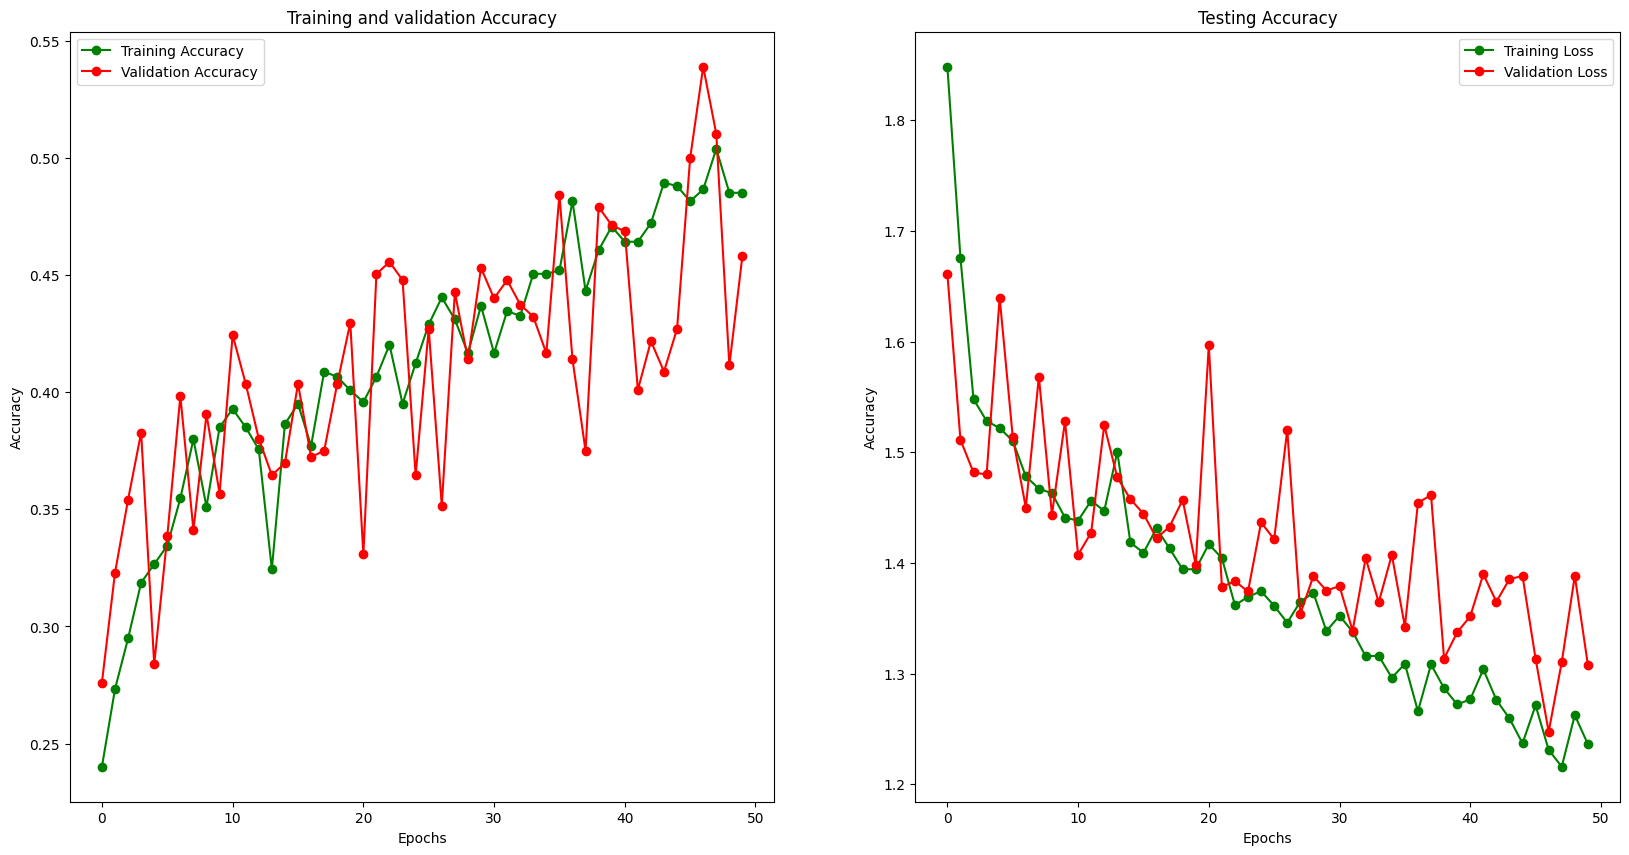

In [22]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [ ]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture No-2

In [13]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
# for layer in base_model.layers[-20:]:  # Change the number of layers to unfreeze as needed
#     layer.trainable = True

# inp = Input((img_height, img_width, 3))
# top_model = base_model(inp)
# top_model = Flatten(name = 'Flatten')(top_model)

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50


2024-07-24 00:15:20.559142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-07-24 00:15:20.640793: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 35.41MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-24 00:15:20.640871: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 35.41MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-24 00:15:20.640893: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 35.41MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains i

44/44 [==============================] - ETA: 0s - loss: 1.7775 - accuracy: 0.2596

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 25s 399ms/step - loss: 1.7775 - accuracy: 0.2596 - val_loss: 1.6661 - val_accuracy: 0.2240
Epoch 2/50
44/44 [==============================] - 16s 367ms/step - loss: 1.5641 - accuracy: 0.3280 - val_loss: 1.5382 - val_accuracy: 0.2995
Epoch 3/50
44/44 [==============================] - 16s 371ms/step - loss: 1.4836 - accuracy: 0.3583 - val_loss: 1.4950 - val_accuracy: 0.3359
Epoch 4/50
44/44 [==============================] - 16s 368ms/step - loss: 1.3988 - accuracy: 0.4088 - val_loss: 1.4562 - val_accuracy: 0.3646
Epoch 5/50
44/44 [==============================] - 16s 366ms/step - loss: 1.3891 - accuracy: 0.4110 - val_loss: 1.4334 - val_accuracy: 0.3724
Epoch 6/50
44/44 [==============================] - 16s 371ms/step - loss: 1.3282 - accuracy: 0.4621 - val_loss: 1.3543 - val_accuracy: 0.4427
Epoch 7/50
44/44 [==============================] - 16s 363ms/step - loss: 1.3022 - accuracy: 0.4643 - val_loss: 1.3210 - val_accuracy: 0.4635
Epoch 8/50

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 84ms/step - loss: 0.9546 - accuracy: 0.6489
Test accuracy: 0.65


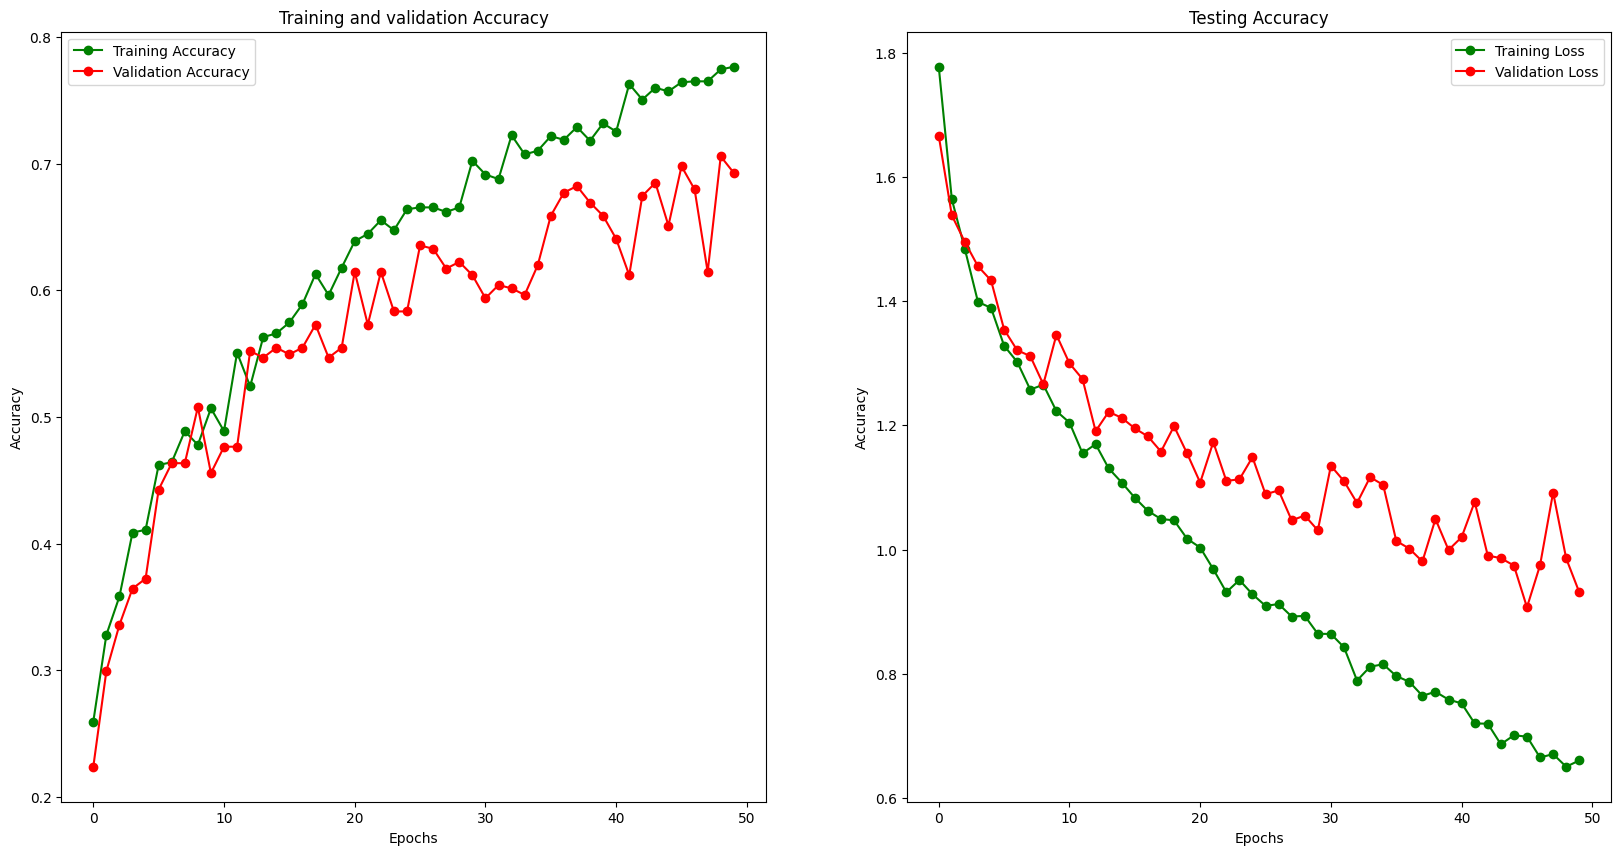

In [16]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [ ]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture no-3

In [17]:
from sklearn.metrics import roc_curve, auc

In [11]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

# inp = Input((img_height, img_width, 3))
# top_model = base_model(inp)
# top_model = Flatten(name = 'Flatten')(top_model)

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_3.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-07-24 11:47:19.274279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 571 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50


2024-07-24 11:47:33.558158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-07-24 11:47:33.825796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-24 11:47:34.078717: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff485d96d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-24 11:47:34.078748: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-07-24 11:47:34.084180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 11:47:34.227860: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

44/44 [==============================] - ETA: 0s - loss: 1.8166 - accuracy: 0.2502

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 25s 402ms/step - loss: 1.8166 - accuracy: 0.2502 - val_loss: 1.5761 - val_accuracy: 0.2786
Epoch 2/50
44/44 [==============================] - 16s 364ms/step - loss: 1.5953 - accuracy: 0.3122 - val_loss: 1.5344 - val_accuracy: 0.3203
Epoch 3/50
44/44 [==============================] - 16s 362ms/step - loss: 1.5188 - accuracy: 0.3627 - val_loss: 1.4970 - val_accuracy: 0.3464
Epoch 4/50
44/44 [==============================] - 16s 357ms/step - loss: 1.4406 - accuracy: 0.4030 - val_loss: 1.4345 - val_accuracy: 0.4141
Epoch 5/50
44/44 [==============================] - 16s 365ms/step - loss: 1.3786 - accuracy: 0.4160 - val_loss: 1.3674 - val_accuracy: 0.4271
Epoch 6/50
44/44 [==============================] - 16s 361ms/step - loss: 1.3239 - accuracy: 0.4484 - val_loss: 1.3500 - val_accuracy: 0.4141
Epoch 7/50
44/44 [==============================] - 15s 342ms/step - loss: 1.3030 - accuracy: 0.4780 - val_loss: 1.3557 - val_accuracy: 0.4349
Epoch 8/50

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 89ms/step - loss: 0.8560 - accuracy: 0.7000
Test accuracy: 0.70


In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 75ms/step - loss: 0.8616 - accuracy: 0.7267
Test accuracy: 0.73


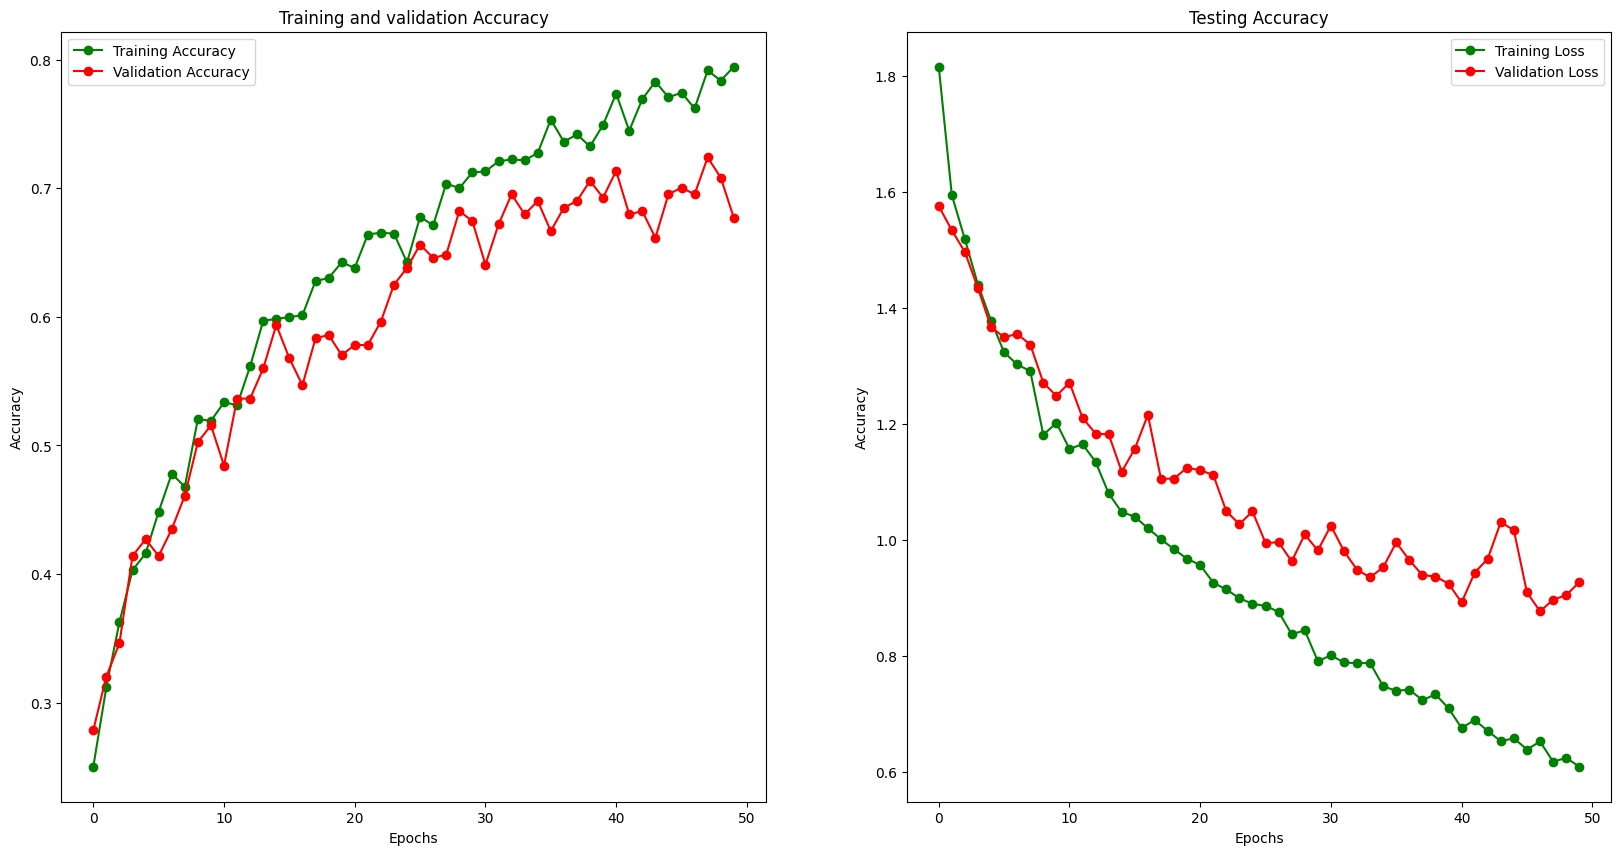

In [15]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 1s 73ms/step


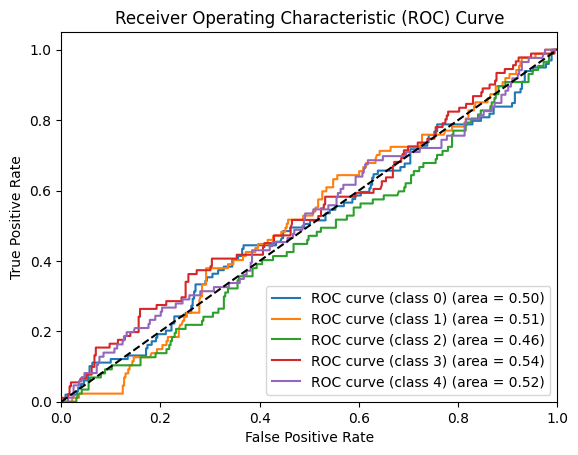

In [18]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture No 4

In [21]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

# inp = Input((img_height, img_width, 3))
# top_model = base_model(inp)
# top_model = Flatten(name = 'Flatten')(top_model)

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
44/44 [==============================] - 24s 391ms/step - loss: 1.8056 - accuracy: 0.2538 - val_loss: 1.6098 - val_accuracy: 0.2396
Epoch 2/50
44/44 [==============================] - 16s 362ms/step - loss: 1.5780 - accuracy: 0.3266 - val_loss: 1.5273 - val_accuracy: 0.3047
Epoch 3/50
44/44 [==============================] - 16s 365ms/step - loss: 1.5035 - accuracy: 0.3605 - val_loss: 1.4739 - val_accuracy: 0.3750
Epoch 4/50
44/44 [==============================] - 17s 376ms/step - loss: 1.4293 - accuracy: 0.3893 - val_loss: 1.4364 - val_accuracy: 0.4141
Epoch 5/50
44/44 [==============================] - 16s 372ms/step - loss: 1.3890 - accuracy: 0.4304 - val_loss: 1.3975 - val_accuracy: 0.4089
Epoch 6/50
44/44 [==============================] - 16s 370ms/step - loss: 1.3317 - accuracy: 0.4489 - val_loss: 1.3872 - val_accuracy: 0.4323
Epoch 7/50
44/44 [==============================] - 16s 366ms/step - loss: 1.3075 - accuracy: 0.4571 - val_loss: 1.3325 - val_accuracy: 0.4505

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 85ms/step - loss: 0.9034 - accuracy: 0.6911
Test accuracy: 0.69


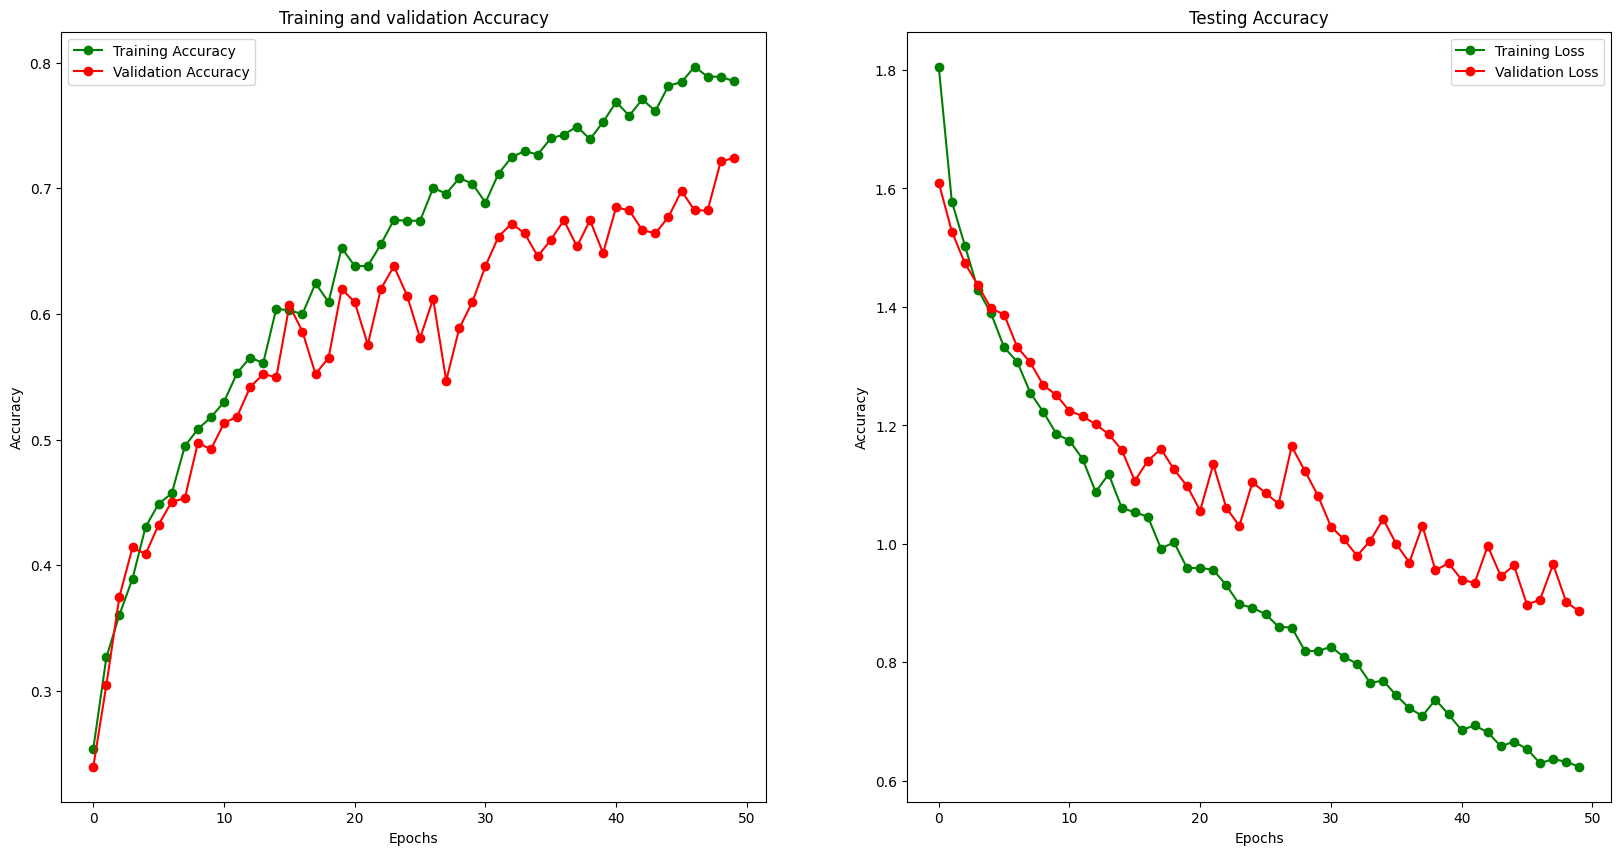

In [24]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [ ]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture No 5

In [16]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

# inp = Input((img_height, img_width, 3))
# top_model = base_model(inp)
# top_model = Flatten(name = 'Flatten')(top_model)

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1= 0.9, beta_2 = 0.999, epsilon = 0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
44/44 [==============================] - 24s 391ms/step - loss: 1.9498 - accuracy: 0.2040 - val_loss: 1.7105 - val_accuracy: 0.1901
Epoch 2/50
44/44 [==============================] - 16s 364ms/step - loss: 1.9052 - accuracy: 0.2048 - val_loss: 1.7053 - val_accuracy: 0.1745
Epoch 3/50
44/44 [==============================] - 16s 371ms/step - loss: 1.8827 - accuracy: 0.2098 - val_loss: 1.6788 - val_accuracy: 0.1875
Epoch 4/50
44/44 [==============================] - 16s 370ms/step - loss: 1.7990 - accuracy: 0.2329 - val_loss: 1.6686 - val_accuracy: 0.2188
Epoch 5/50
44/44 [==============================] - 17s 379ms/step - loss: 1.8110 - accuracy: 0.2221 - val_loss: 1.6568 - val_accuracy: 0.2344
Epoch 6/50
44/44 [==============================] - 16s 370ms/step - loss: 1.7534 - accuracy: 0.2430 - val_loss: 1.6517 - val_accuracy: 0.2448
Epoch 7/50
44/44 [==============================] - 16s 368ms/step - loss: 1.7432 - accuracy: 0.2422 - val_loss: 1.6320 - val_accuracy: 0.2656

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 93ms/step - loss: 1.3791 - accuracy: 0.4378
Test accuracy: 0.44


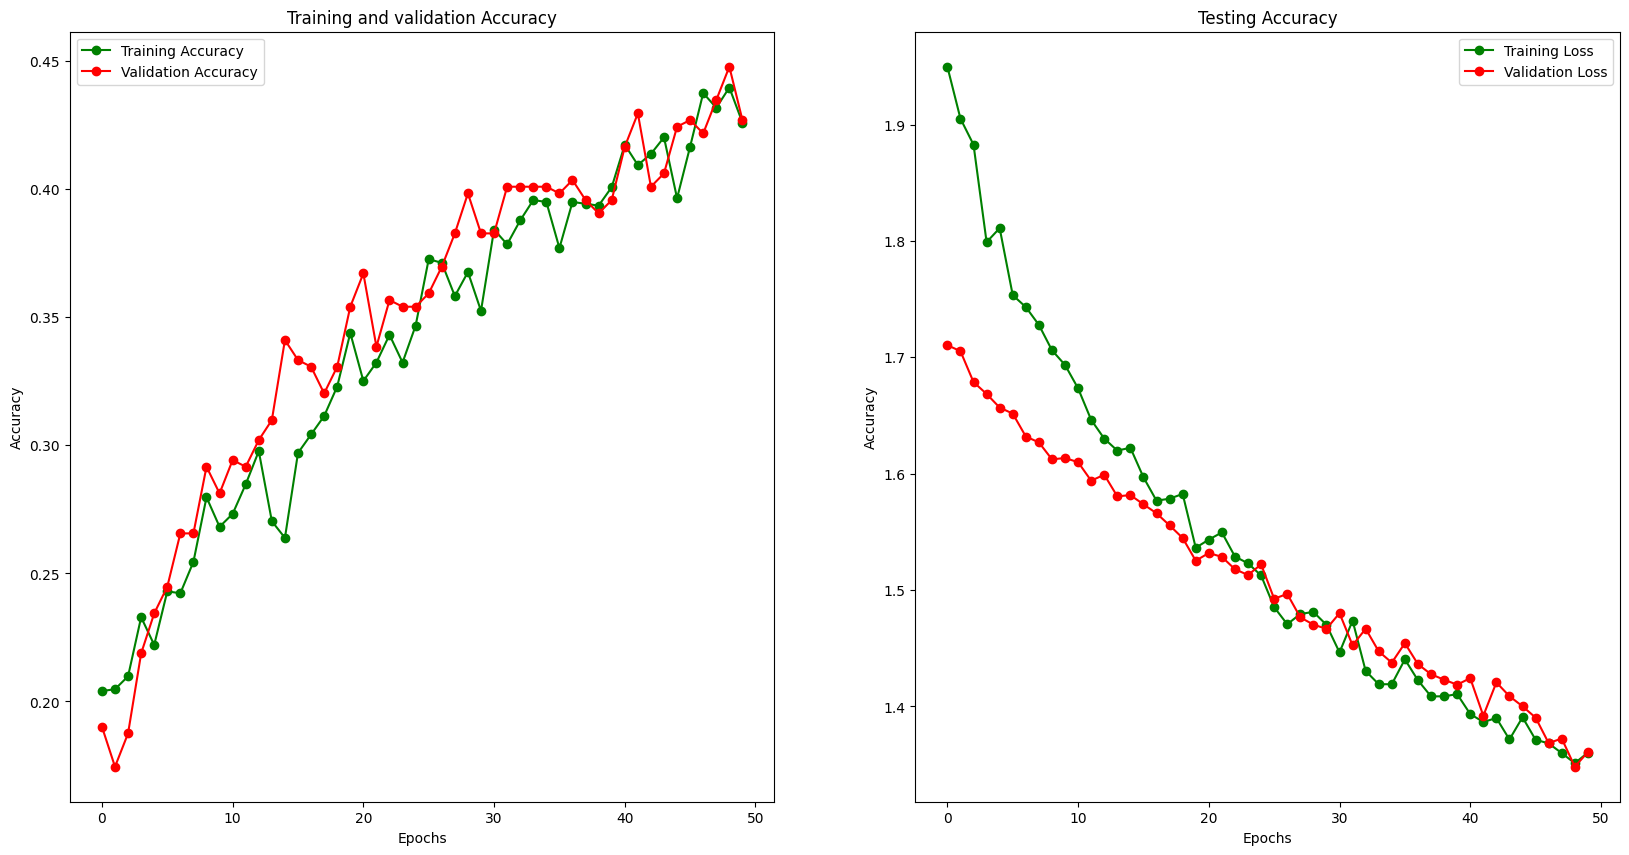

In [19]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [ ]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture No - 6

In [20]:
from tensorflow.keras.layers import Dropout

In [21]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

# inp = Input((img_height, img_width, 3))
# top_model = base_model(inp)
# top_model = Flatten(name = 'Flatten')(top_model)

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1= 0.9, beta_2 = 0.999, epsilon = 0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - 25s 402ms/step - loss: 1.8855 - accuracy: 0.1997 - val_loss: 1.6848 - val_accuracy: 0.1979
Epoch 2/50
44/44 [==============================] - 16s 372ms/step - loss: 1.8722 - accuracy: 0.1947 - val_loss: 1.6663 - val_accuracy: 0.1875
Epoch 3/50
44/44 [==============================] - 17s 381ms/step - loss: 1.8366 - accuracy: 0.1932 - val_loss: 1.6491 - val_accuracy: 0.2005
Epoch 4/50
44/44 [==============================] - 16s 354ms/step - loss: 1.8179 - accuracy: 0.2076 - val_loss: 1.6596 - val_accuracy: 0.1797
Epoch 5/50
44/44 [==============================] - 15s 347ms/step - loss: 1.7929 - accuracy: 0.2134 - val_loss: 1.6650 - val_accuracy: 0.1797
Epoch 6/50
44/44 [==============================] - 15s 347ms/step - loss: 1.7772 - accuracy: 0.2206 - val_loss: 1.6700 - val_accuracy: 0.1927
Epoch 7/50
44/44 [==============================] - 15s 345ms/step - loss: 1.7407 - accuracy: 0.2242 - val_loss: 1.6734 - val_accuracy: 0.2031

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 78ms/step - loss: 1.4598 - accuracy: 0.3800
Test accuracy: 0.38


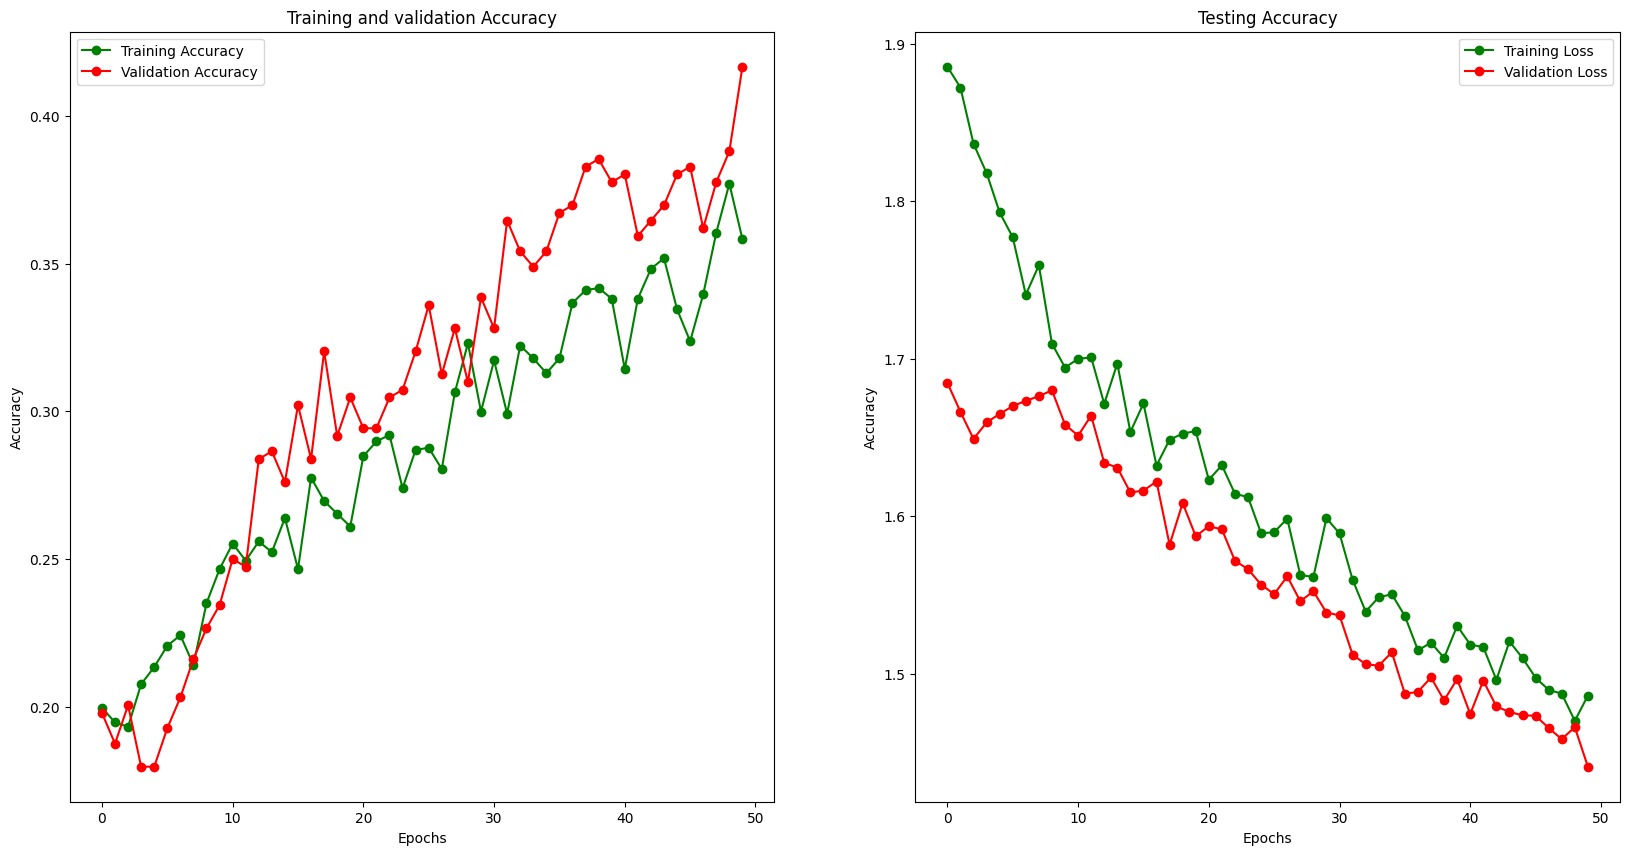

In [24]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [ ]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture No 7

In [26]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

# inp = Input((img_height, img_width, 3))
# top_model = base_model(inp)
# top_model = Flatten(name = 'Flatten')(top_model)
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [27]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - 25s 396ms/step - loss: 1.8037 - accuracy: 0.2394 - val_loss: 1.6288 - val_accuracy: 0.2318
Epoch 2/50
44/44 [==============================] - 17s 377ms/step - loss: 1.6365 - accuracy: 0.2841 - val_loss: 1.5227 - val_accuracy: 0.3359
Epoch 3/50
44/44 [==============================] - 17s 381ms/step - loss: 1.5574 - accuracy: 0.3208 - val_loss: 1.4768 - val_accuracy: 0.3932
Epoch 4/50
44/44 [==============================] - 16s 354ms/step - loss: 1.5298 - accuracy: 0.3353 - val_loss: 1.4800 - val_accuracy: 0.3984
Epoch 5/50
44/44 [==============================] - 16s 365ms/step - loss: 1.5002 - accuracy: 0.3576 - val_loss: 1.4533 - val_accuracy: 0.3698
Epoch 6/50
44/44 [==============================] - 17s 383ms/step - loss: 1.4564 - accuracy: 0.3670 - val_loss: 1.4491 - val_accuracy: 0.3932
Epoch 7/50
44/44 [==============================] - 17s 378ms/step - loss: 1.4143 - accuracy: 0.4095 - val_loss: 1.3853 - val_accuracy: 0.4323

In [28]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 85ms/step - loss: 0.9450 - accuracy: 0.6489
Test accuracy: 0.65


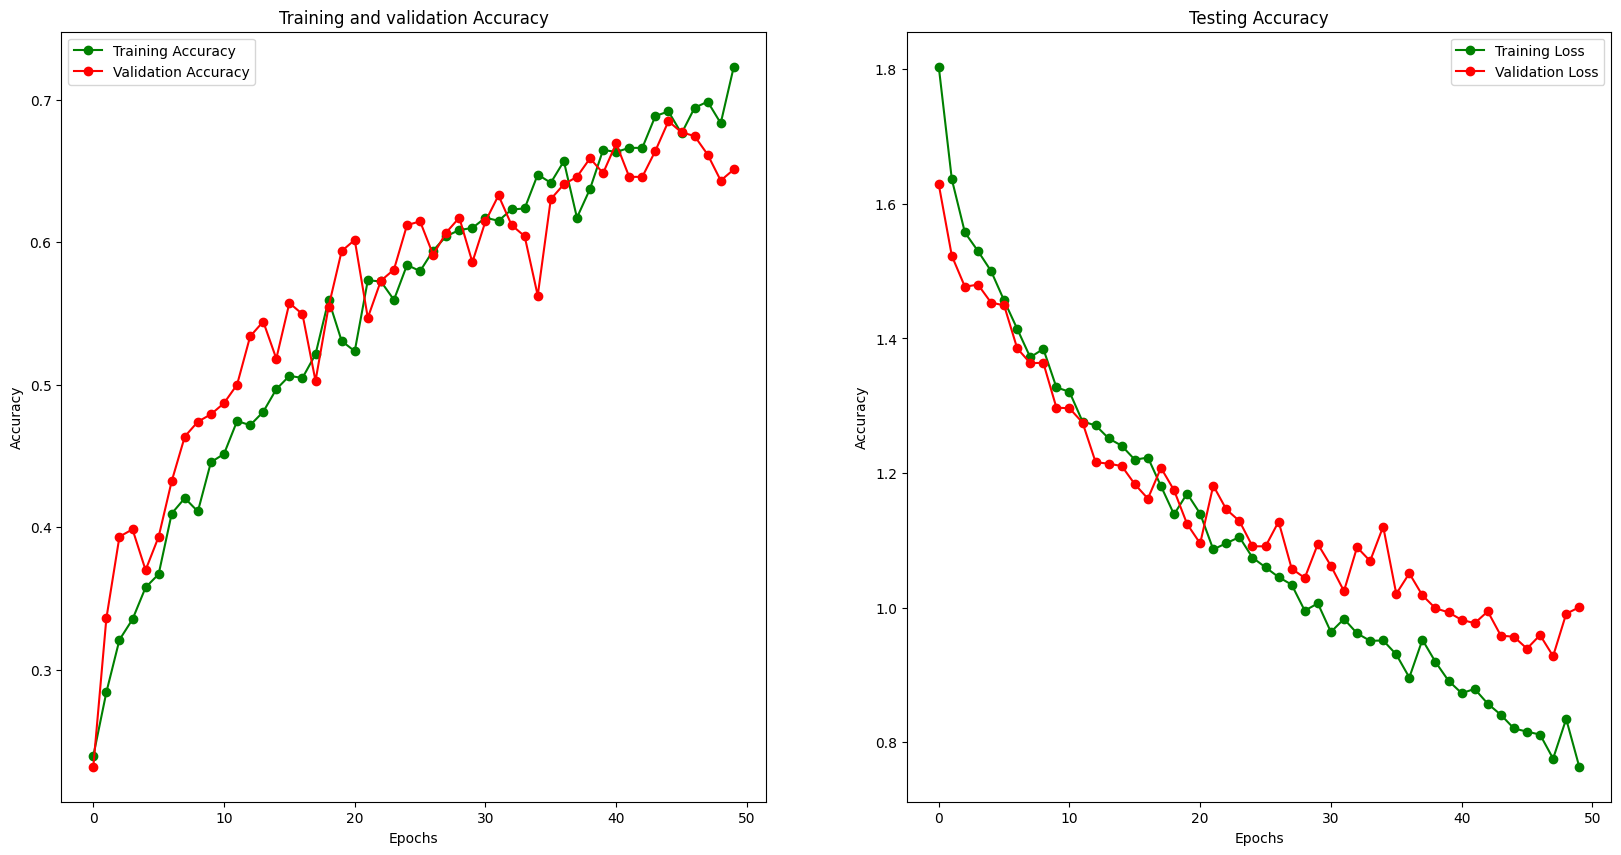

In [29]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 1s 89ms/step


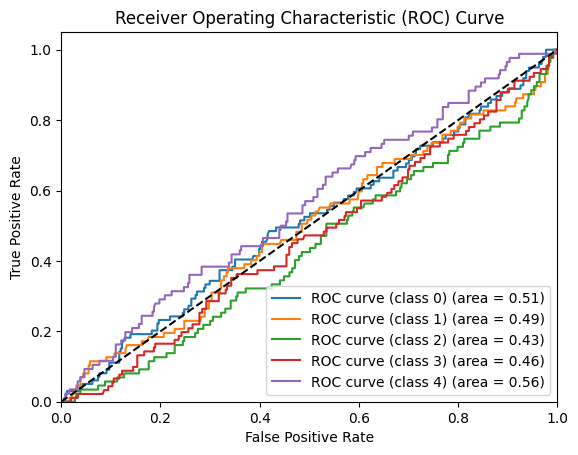

In [52]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture no 8

In [55]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True


top_model = base_model.output
top_model = GlobalAveragePooling2D(input_shape=(1024,1,1))(top_model)
# Add a flattern layer
top_model = Dense(2048, activation= 'relu', name = 'Dense_2048')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

# Add a fully-connected layer
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

predictions = Dense(num_classes, activation = 'sigmoid', name= 'Output_layer')(top_model)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_8.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [56]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.3331 - accuracy: 0.2055

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 25s 406ms/step - loss: 2.3331 - accuracy: 0.2055 - val_loss: 1.6194 - val_accuracy: 0.2552
Epoch 2/50
44/44 [==============================] - 16s 373ms/step - loss: 2.0100 - accuracy: 0.2797 - val_loss: 1.5753 - val_accuracy: 0.2969
Epoch 3/50
44/44 [==============================] - 16s 362ms/step - loss: 1.8554 - accuracy: 0.3381 - val_loss: 1.5050 - val_accuracy: 0.3359
Epoch 4/50
44/44 [==============================] - 16s 367ms/step - loss: 1.7769 - accuracy: 0.3288 - val_loss: 1.4285 - val_accuracy: 0.4141
Epoch 5/50
44/44 [==============================] - 15s 346ms/step - loss: 1.6484 - accuracy: 0.3713 - val_loss: 1.4360 - val_accuracy: 0.4062
Epoch 6/50
44/44 [==============================] - 16s 366ms/step - loss: 1.6320 - accuracy: 0.3778 - val_loss: 1.4245 - val_accuracy: 0.3932
Epoch 7/50
44/44 [==============================] - 16s 350ms/step - loss: 1.5888 - accuracy: 0.4001 - val_loss: 1.4302 - val_accuracy: 0.4062
Epoch 8/50

In [57]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 81ms/step - loss: 0.9050 - accuracy: 0.6889
Test accuracy: 0.69


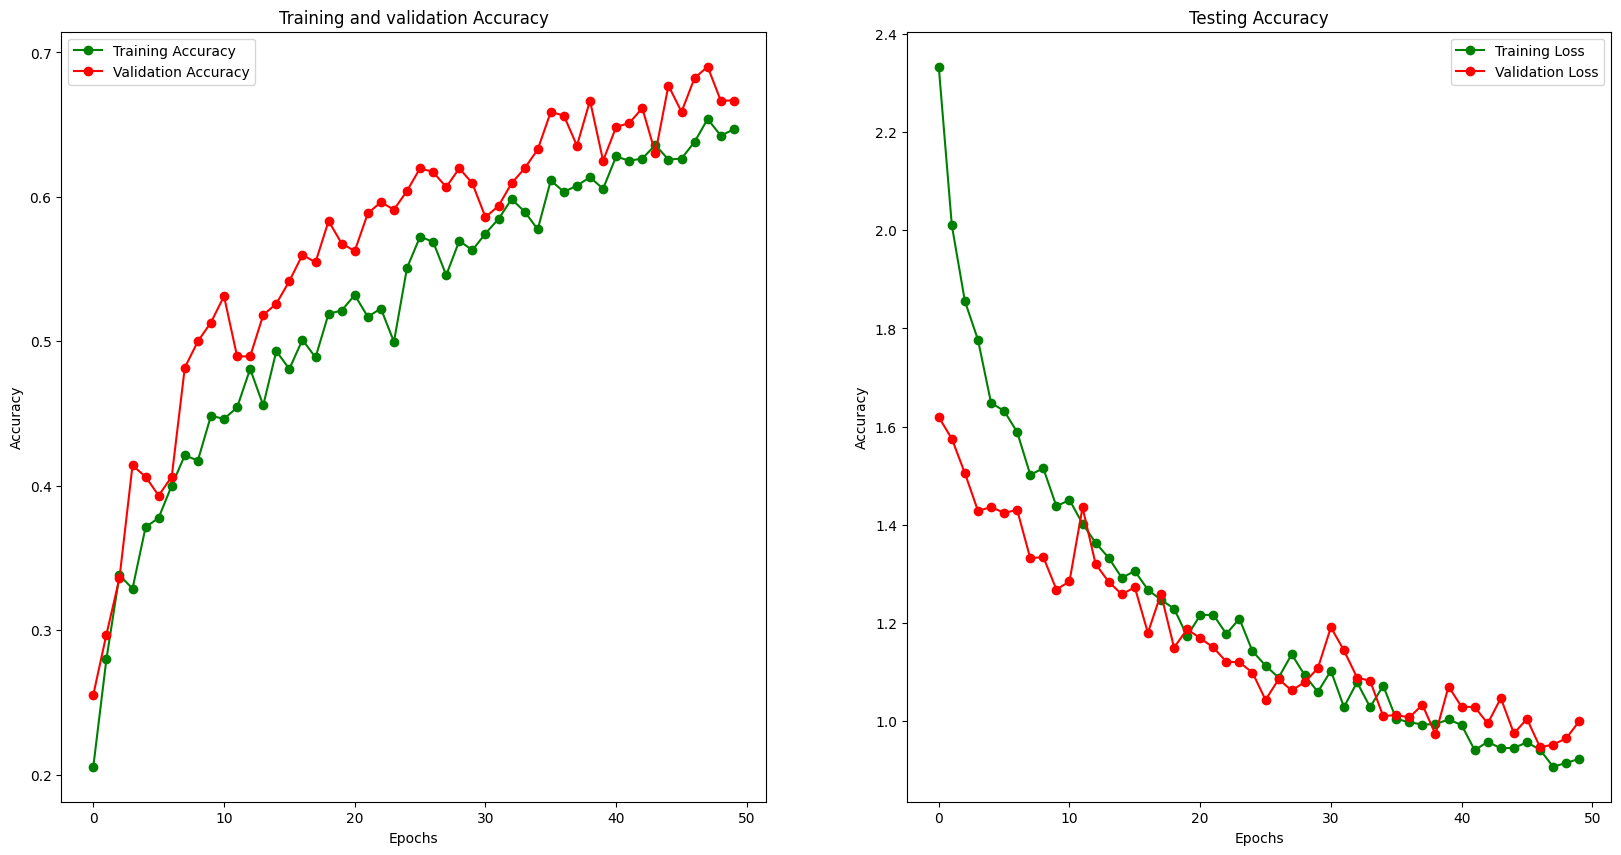

In [58]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 3s 75ms/step


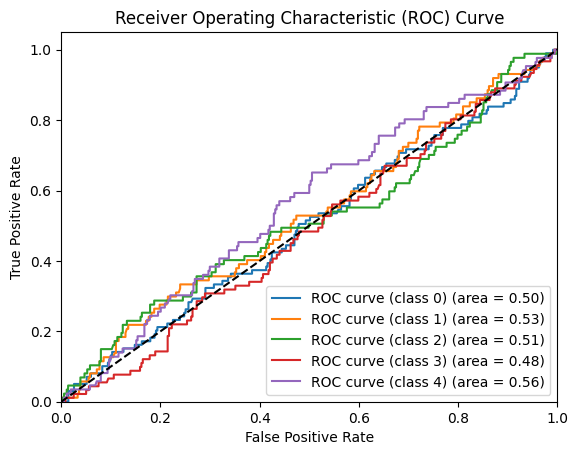

In [59]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture no 9

In [60]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# # Unfreeze the last few layers of the base model
# for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
#     layer.trainable = True


top_model = base_model.output
top_model = GlobalAveragePooling2D(input_shape=(1024,1,1))(top_model)
# Add a flattern layer
top_model = Dense(2048, activation= 'relu', name = 'Dense_2048')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

# Add a fully-connected layer
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

predictions = Dense(num_classes, activation = 'sigmoid', name= 'Output_layer')(top_model)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_9.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [61]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.2120 - accuracy: 0.2343

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 24s 391ms/step - loss: 2.2120 - accuracy: 0.2343 - val_loss: 1.5760 - val_accuracy: 0.2656
Epoch 2/50
44/44 [==============================] - 16s 367ms/step - loss: 2.0009 - accuracy: 0.2675 - val_loss: 1.5141 - val_accuracy: 0.3464
Epoch 3/50
44/44 [==============================] - 16s 365ms/step - loss: 1.8636 - accuracy: 0.2927 - val_loss: 1.5058 - val_accuracy: 0.3646
Epoch 4/50
44/44 [==============================] - 16s 357ms/step - loss: 1.7673 - accuracy: 0.3417 - val_loss: 1.4937 - val_accuracy: 0.3906
Epoch 5/50
44/44 [==============================] - 16s 372ms/step - loss: 1.6956 - accuracy: 0.3576 - val_loss: 1.4257 - val_accuracy: 0.3932
Epoch 6/50
44/44 [==============================] - 16s 364ms/step - loss: 1.6225 - accuracy: 0.3800 - val_loss: 1.3712 - val_accuracy: 0.4245
Epoch 7/50
44/44 [==============================] - 15s 344ms/step - loss: 1.5814 - accuracy: 0.3987 - val_loss: 1.4205 - val_accuracy: 0.4010
Epoch 8/50

In [62]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 64ms/step - loss: 0.9845 - accuracy: 0.6333
Test accuracy: 0.63


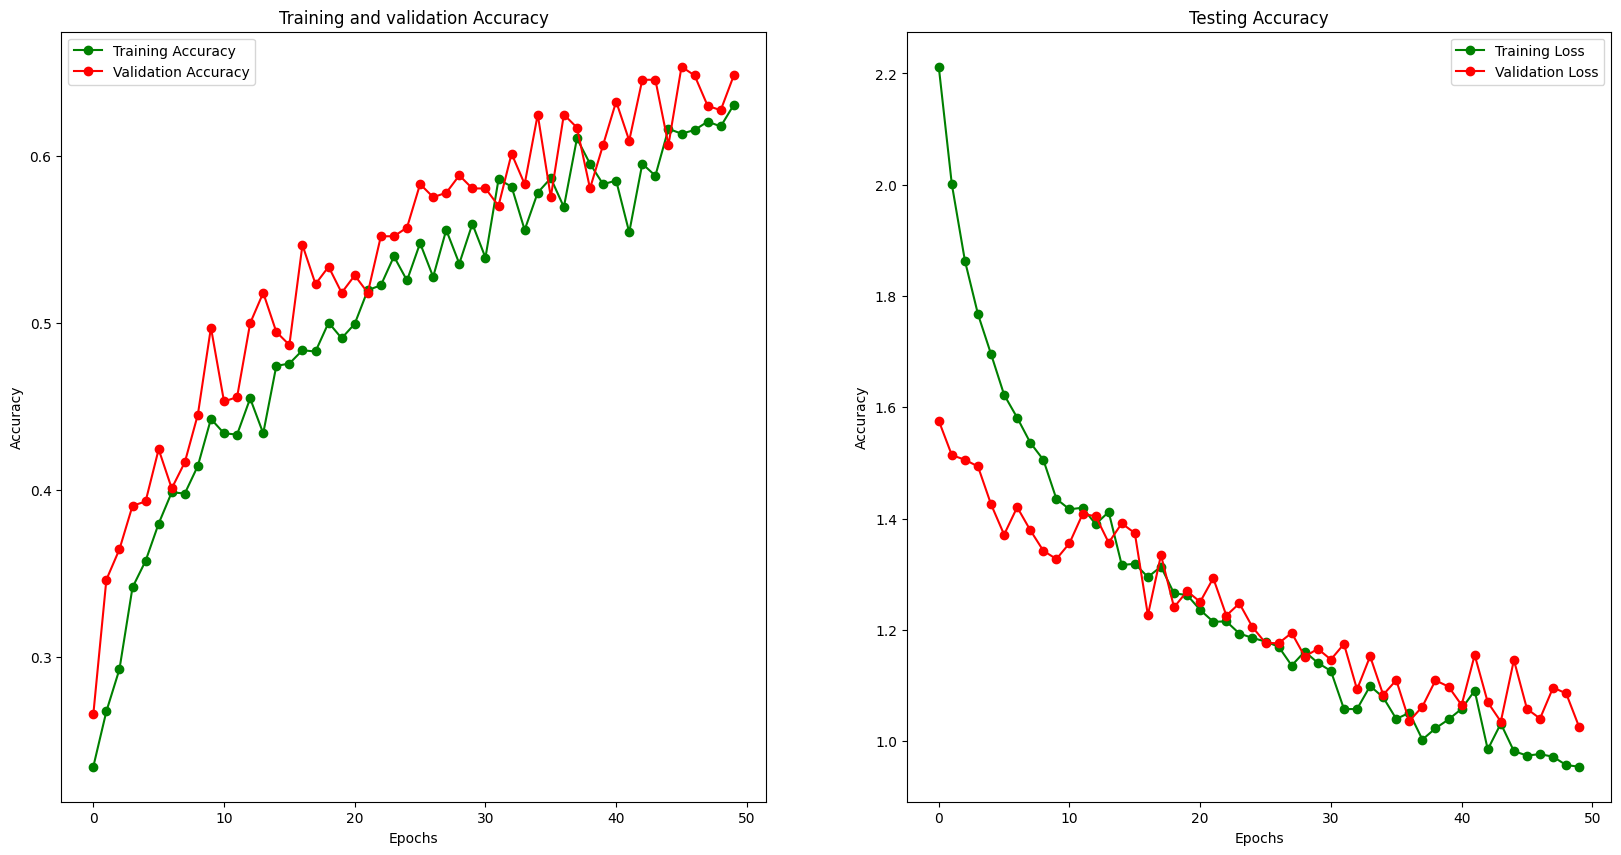

In [63]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 3s 74ms/step


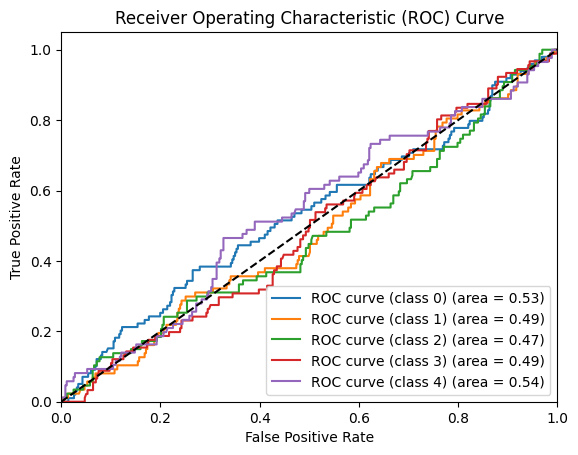

In [64]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture no 10

In [74]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# # Unfreeze the last few layers of the base model
# for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
#     layer.trainable = True


top_model = base_model.output
top_model = GlobalAveragePooling2D(input_shape=(1024,1,1))(top_model)
# Add a flattern layer
top_model = Dense(2048, activation= 'relu', name = 'Dense_2048')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

# Add a fully-connected layer
top_model = Dense(1024, activation='relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

predictions = Dense(num_classes, activation = 'sigmoid', name= 'Output_layer')(top_model)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_10.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [78]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    # callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - 16s 356ms/step - loss: 1.2286 - accuracy: 0.5126 - val_loss: 1.2289 - val_accuracy: 0.5286
Epoch 2/50
44/44 [==============================] - 15s 344ms/step - loss: 1.3181 - accuracy: 0.4917 - val_loss: 1.4289 - val_accuracy: 0.4505
Epoch 3/50
44/44 [==============================] - 15s 342ms/step - loss: 1.2830 - accuracy: 0.4845 - val_loss: 1.3433 - val_accuracy: 0.4974
Epoch 4/50
44/44 [==============================] - 16s 354ms/step - loss: 1.2738 - accuracy: 0.5105 - val_loss: 1.5141 - val_accuracy: 0.4688
Epoch 5/50
44/44 [==============================] - 16s 352ms/step - loss: 1.1994 - accuracy: 0.5256 - val_loss: 1.5725 - val_accuracy: 0.4375
Epoch 6/50
44/44 [==============================] - 15s 343ms/step - loss: 1.2324 - accuracy: 0.5032 - val_loss: 1.5663 - val_accuracy: 0.4427
Epoch 7/50
44/44 [==============================] - 15s 343ms/step - loss: 1.1252 - accuracy: 0.5552 - val_loss: 1.3781 - val_accuracy: 0.5104

In [79]:

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')


15/15 [==============================] - 1s 75ms/step - loss: 1.1758 - accuracy: 0.6267
Test accuracy: 0.63


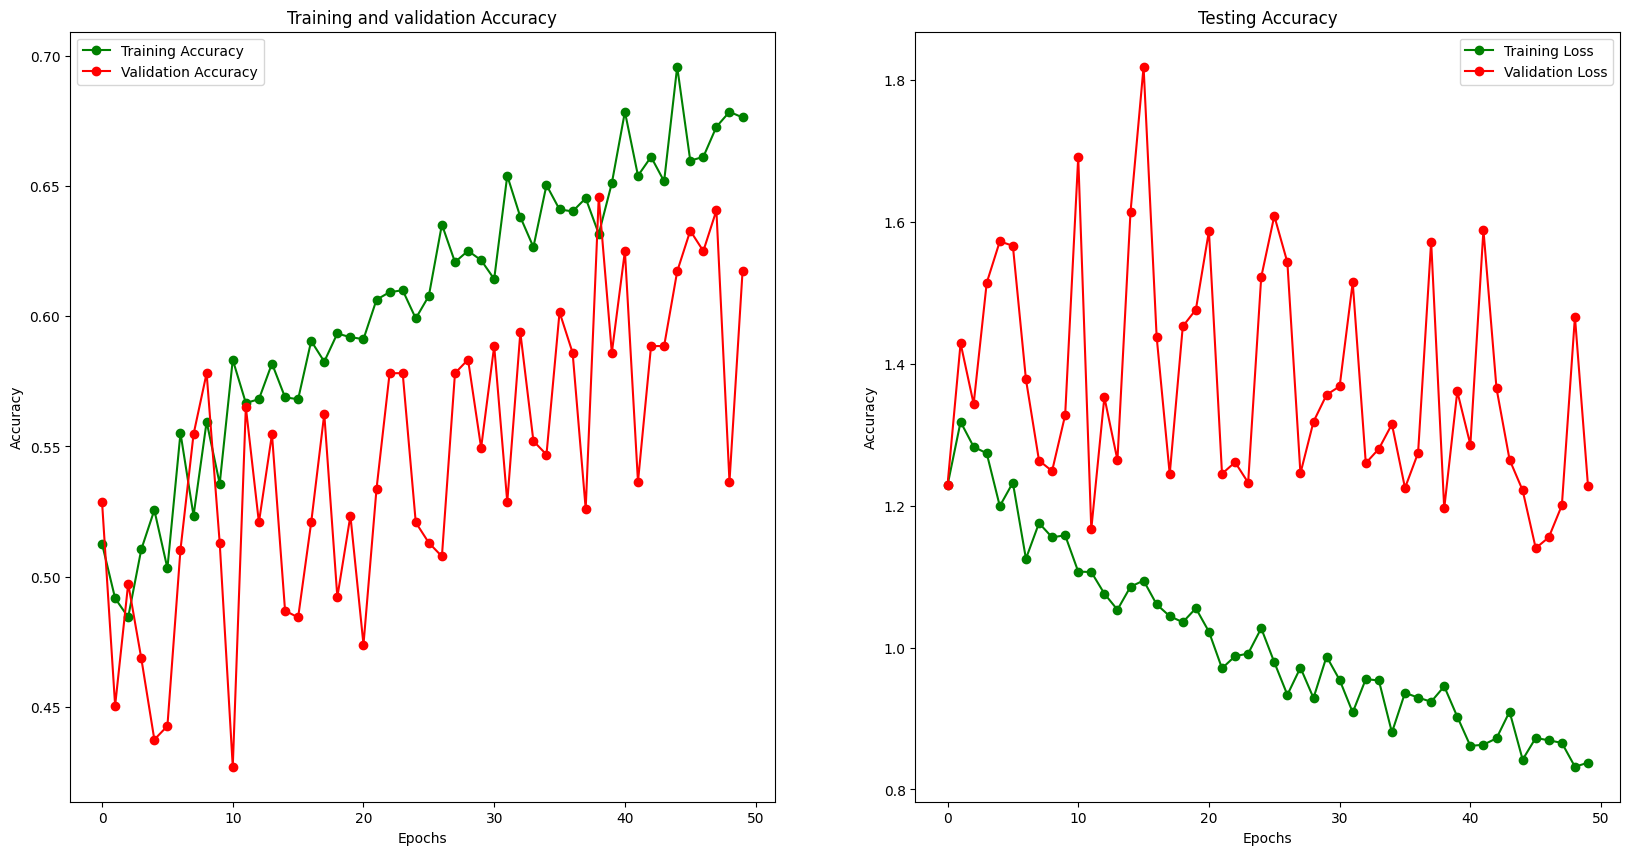

In [80]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 3s 79ms/step


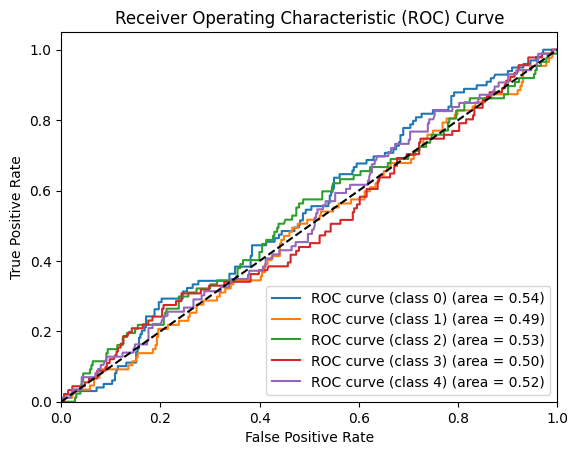

In [81]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture no 11

In [82]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# # Unfreeze the last few layers of the base model
# for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
#     layer.trainable = True


top_model = base_model.output
top_model = GlobalAveragePooling2D(input_shape=(1024,1,1))(top_model)
# Add a flattern layer
top_model = Dense(2048, activation= 'relu', name = 'Dense_2048')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

# Add a fully-connected layer
top_model = Dense(1024, activation='relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.2)(top_model)

predictions = Dense(num_classes, activation = 'sigmoid', name= 'Output_layer')(top_model)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_11.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [83]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    # callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - 24s 376ms/step - loss: 0.3128 - accuracy: 0.2350 - val_loss: 0.2316 - val_accuracy: 0.3021
Epoch 2/50
44/44 [==============================] - 16s 351ms/step - loss: 0.2821 - accuracy: 0.3064 - val_loss: 0.2251 - val_accuracy: 0.3568
Epoch 3/50
44/44 [==============================] - 16s 352ms/step - loss: 0.2665 - accuracy: 0.3295 - val_loss: 0.2092 - val_accuracy: 0.3906
Epoch 4/50
44/44 [==============================] - 15s 351ms/step - loss: 0.2508 - accuracy: 0.3554 - val_loss: 0.1875 - val_accuracy: 0.4401
Epoch 5/50
44/44 [==============================] - 15s 345ms/step - loss: 0.2398 - accuracy: 0.3872 - val_loss: 0.2029 - val_accuracy: 0.3984
Epoch 6/50
44/44 [==============================] - 15s 344ms/step - loss: 0.2288 - accuracy: 0.3735 - val_loss: 0.1893 - val_accuracy: 0.4271
Epoch 7/50
44/44 [==============================] - 15s 346ms/step - loss: 0.2171 - accuracy: 0.4001 - val_loss: 0.1897 - val_accuracy: 0.4922

In [84]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 72ms/step - loss: 0.1014 - accuracy: 0.6489
Test accuracy: 0.65


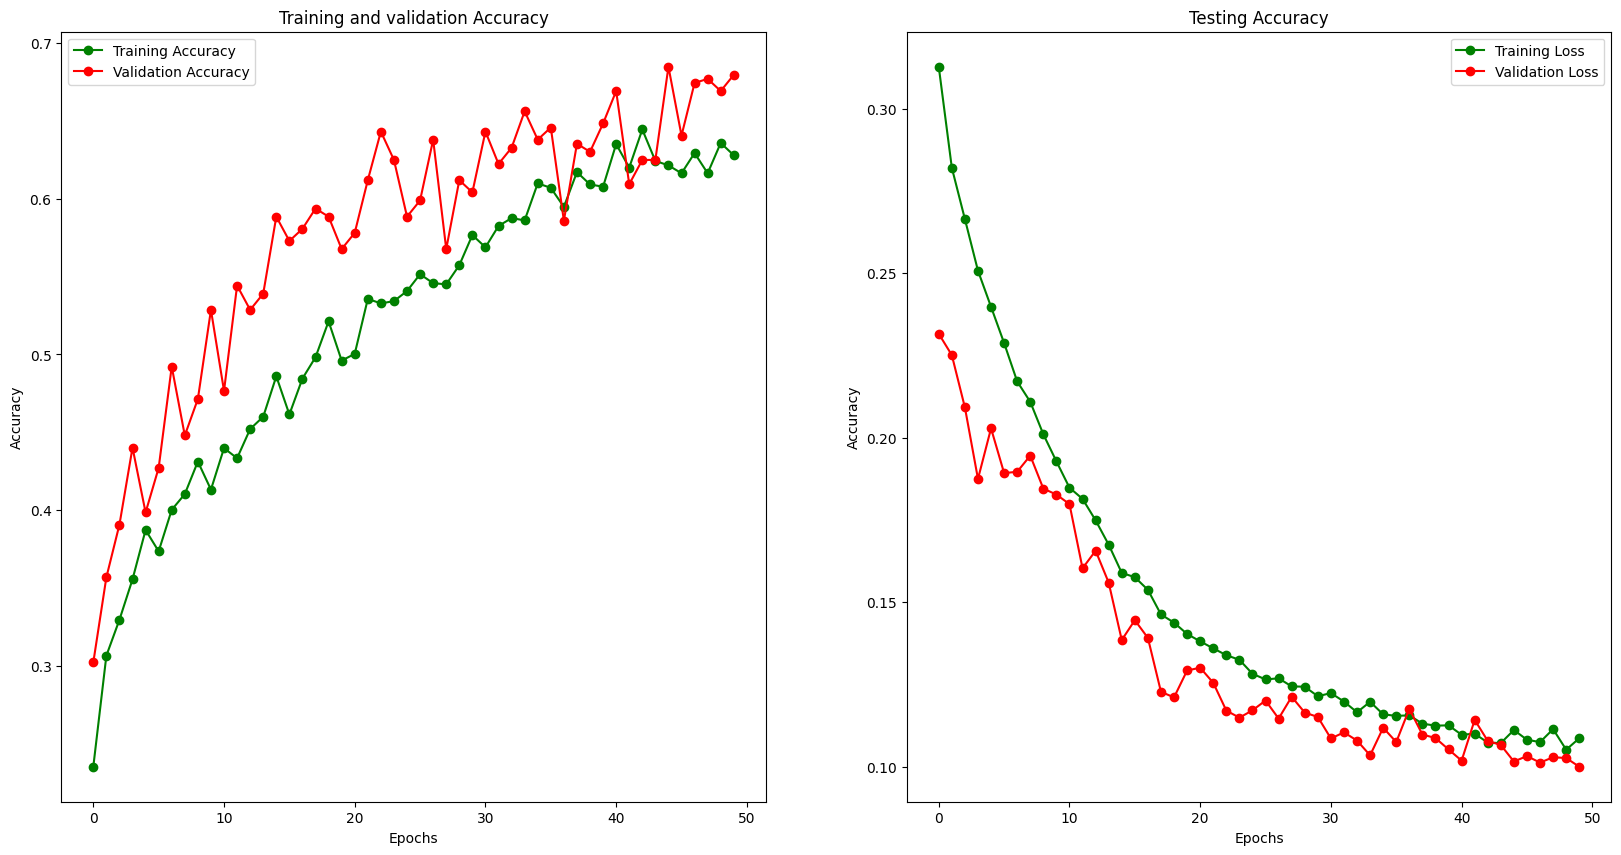

In [85]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 3s 76ms/step


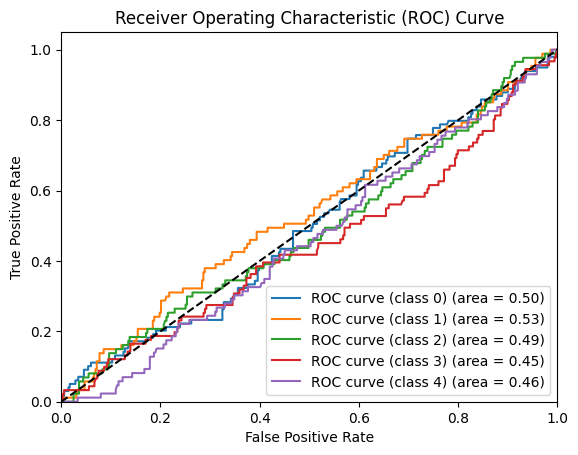

In [86]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 12

In [87]:
# Load pre-trained DenseNet121 and customize the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)

top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_12.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [88]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.2280

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 24s 410ms/step - loss: 0.1769 - accuracy: 0.2280 - val_loss: 0.1608 - val_accuracy: 0.2344
Epoch 2/50
44/44 [==============================] - 17s 381ms/step - loss: 0.1631 - accuracy: 0.2949 - val_loss: 0.1541 - val_accuracy: 0.3073
Epoch 3/50
44/44 [==============================] - 16s 366ms/step - loss: 0.1548 - accuracy: 0.3381 - val_loss: 0.1495 - val_accuracy: 0.3698
Epoch 4/50
44/44 [==============================] - 17s 377ms/step - loss: 0.1489 - accuracy: 0.3699 - val_loss: 0.1449 - val_accuracy: 0.4062
Epoch 5/50
44/44 [==============================] - 17s 377ms/step - loss: 0.1416 - accuracy: 0.4146 - val_loss: 0.1429 - val_accuracy: 0.4401
Epoch 6/50
44/44 [==============================] - 16s 374ms/step - loss: 0.1380 - accuracy: 0.4333 - val_loss: 0.1366 - val_accuracy: 0.4714
Epoch 7/50
44/44 [==============================] - 17s 373ms/step - loss: 0.1345 - accuracy: 0.4492 - val_loss: 0.1349 - val_accuracy: 0.4740
Epoch 8/50

In [89]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 1s 88ms/step - loss: 0.0920 - accuracy: 0.6622
Test accuracy: 0.66


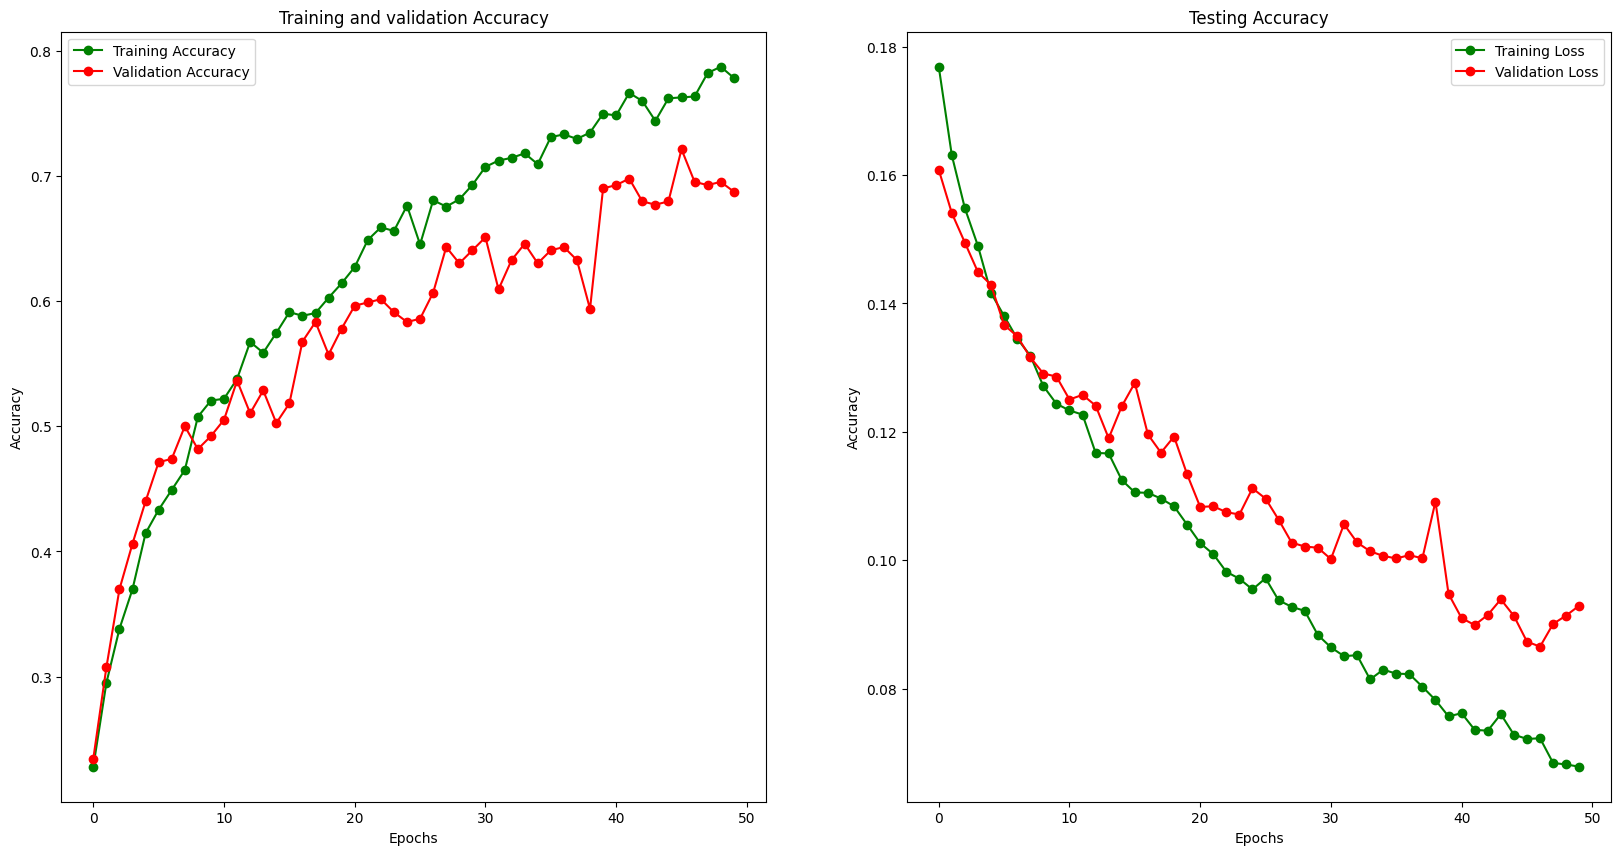

In [90]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 3s 81ms/step


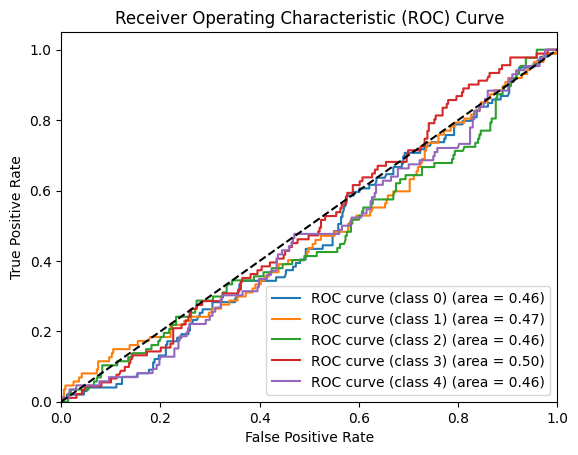

In [91]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()